In [1]:
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(scales))

**This tutorial is for R users. If you are a Python user, check out [this other tutorial instead!](https://quentinandre.net/post/clean-analyze-distbuilder-data-python)**

You have just completed a simple distribution builder study on a Qualtrics.
* Participants have been randomly assigned to one of two conditions (“Low” or “High”), and have learned a distribution of numbers ranging from 11 to 20.
* After learning the distribution, they had to predict the next 10 numbers that would appear in the distribution.
* To do so, they allocated 10 balls (representing the next 10 draws) to 10 buckets [11, 12, 13, 14, 15, 16, 17, 18, 19, 20] (representing the possible outcomes).

Here is the data for the first five participants:

In [2]:
text <- ("A,Low,'3,1,0,2,1,0,0,0,1,2'
B,High,'0,0,2,0,2,0,1,2,0,3'
C,High,'3,0,0,2,1,0,0,0,3,1'
D,Low,'2,1,0,2,0,1,2,0,1,1'
E,Low,'3,2,0,0,0,1,0,3,0,1'
F,High,'0,0,2,0,0,1,2,0,2,3'
G,Low,'1,3,0,3,0,2,0,1,0,0'
H,High,'0,1,3,0,0,1,2,2,1,0'
I,High,'2,2,0,0,0,2,1,0,0,3'
J,Low,'1,3,1,0,2,2,0,0,0,1'
K,Low,'1,3,1,0,0,1,2,1,1,0'
L,Low,'3,1,2,1,0,1,0,1,0,1'
M,Low,'0,2,2,0,1,3,0,2,0,0'
N,Low,'1,3,0,2,0,1,1,1,1,0'
O,High,'0,0,1,3,1,0,0,3,0,2'
P,High,'1,1,2,0,0,0,2,0,2,2'
Q,High,'1,1,0,0,0,0,3,2,2,1'
R,High,'2,0,0,0,0,2,3,0,3,0'
S,High,'0,1,3,2,0,0,0,0,1,3'
T,Low,'1,3,1,0,1,0,3,0,0,1'")
data <- read.table(
  text = text, sep = ",",
  col.names = c("part_id", "condition", "allocation")
) %>%
  mutate(condition = factor(condition, levels = c("Low", "High")))
head(data, 5)

,part_id,condition,allocation
,<fct>,<fct>,<fct>
1,A,Low,"3,1,0,2,1,0,0,0,1,2"
2,B,High,"0,0,2,0,2,0,1,2,0,3"
3,C,High,"3,0,0,2,1,0,0,0,3,1"
4,D,Low,"2,1,0,2,0,1,2,0,1,1"
5,E,Low,"3,2,0,0,0,1,0,3,0,1"


## 1. Data Wrangling: Making the raw data usable



If you look at the raw data from Qualtrics, you can see that the column “allocation” has stored the allocation provided by each participant.

However, those allocations are not interpretable right now:

* The allocations are stored as a string (and not as a list of numbers).
* This numbers in this allocation are not the values of the distribution: those are the number of balls in each bucket. You can see that all the values are below 10, while the buckets ranged from 11 to 20.

Let’s review how you should transform this data, and what you can do with it.

### A. Converting the allocations to distributions


The first step is to write a function and convert those allocations to distributions.

In [3]:
convert_allocation_to_distribution <- function(allocation, buckets) {
  # Takes an allocation of balls to buckets, and a list of buckets.  Return the
  # corresponding distribution of values.
  allocation <- as.character(allocation)  # Failsafe in case it was stored as a factor
  list_alloc_num <- unlist(strsplit(allocation, ","))
  list(rep(buckets, list_alloc_num))
}

Now we apply this function to the column “allocation”, specifying that the buckets ranged from 11 to 20.

In [4]:
buckets <- seq(11, 20)  # Our buckets
data <- data %>%
  rowwise %>%
  mutate(distribution = convert_allocation_to_distribution(allocation, buckets)) %>%
  ungroup()
head(data, 5)

part_id,condition,allocation,distribution
<fct>,<fct>,<fct>,<list>
A,Low,"3,1,0,2,1,0,0,0,1,2","11, 11, 11, 12, 14, 14, 15, 19, 20, 20"
B,High,"0,0,2,0,2,0,1,2,0,3","13, 13, 15, 15, 17, 18, 18, 20, 20, 20"
C,High,"3,0,0,2,1,0,0,0,3,1","11, 11, 11, 14, 14, 15, 19, 19, 19, 20"
D,Low,"2,1,0,2,0,1,2,0,1,1","11, 11, 12, 14, 14, 16, 17, 17, 19, 20"
E,Low,"3,2,0,0,0,1,0,3,0,1","11, 11, 11, 12, 12, 16, 18, 18, 18, 20"


Good! The raw allocation strings have now been converted to the actual distribution provided by participants.

However, the data is in a nice shape: the data for each participant is stored as a list of number in a single column. Ideally, we’d like a format that we can use to do analysis and graphs.

### B. Pivoting the distributions in long form

We are now going to reshape the data in long form, such that one record corresponds to one value entered by one participant. This is achieved using the `unnest` function from dplyr.

In [5]:
data_long <- data %>%
  unnest(distribution) %>%
  group_by(part_id) %>%
  mutate(value_index = row_number()) %>%
  ungroup() %>%
  rename(value = distribution)
head(data_long, 10)

part_id,condition,allocation,value,value_index
<fct>,<fct>,<fct>,<int>,<int>
A,Low,"3,1,0,2,1,0,0,0,1,2",11,1
A,Low,"3,1,0,2,1,0,0,0,1,2",11,2
A,Low,"3,1,0,2,1,0,0,0,1,2",11,3
A,Low,"3,1,0,2,1,0,0,0,1,2",12,4
A,Low,"3,1,0,2,1,0,0,0,1,2",14,5
A,Low,"3,1,0,2,1,0,0,0,1,2",14,6
A,Low,"3,1,0,2,1,0,0,0,1,2",15,7
A,Low,"3,1,0,2,1,0,0,0,1,2",19,8
A,Low,"3,1,0,2,1,0,0,0,1,2",20,9


Great! We now have the data in long form. At this stage, it is good practice to double-check that all your participants have entered a full distribution (i.e., that there are 10 values per participant).

In [6]:
data_long %>%
  count(part_id) %>%
  head(5)

part_id,n
<fct>,<int>
A,10
B,10
C,10
D,10
E,10


We are now ready for some dataviz and statistical analysis!

## 2. Visualizing the data

The first thing you can do is to inspect the distributions provided by the participants:

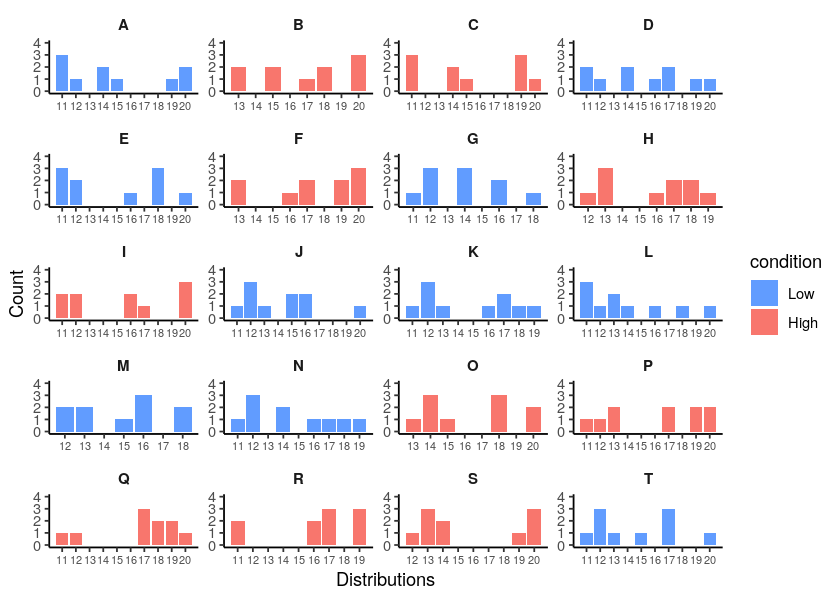

In [29]:
options(repr.plot.width = 7, repr.plot.height =5)
ggplot(data_long) +
facet_wrap(vars(part_id), ncol = 4, scales = "free") +
geom_bar(aes(value, fill = condition)) +
xlab("Distributions") +
ylab("Count") +
scale_x_continuous(breaks = seq(11, 20, 1)) +
scale_y_continuous(limits = c(0, 4)) +
scale_fill_manual(values = c("#619CFF", "#F8766D")) +
theme_classic() +
theme(
  axis.text.x = element_text(size = rel(0.75)),
  strip.text = element_text(face = "bold", size = 9),
  strip.background = element_rect(fill = NULL, colour = "black", size = 0)
)

Those distributions look pretty random (because they were randomly generated), but at least we can see how each participant responded!

Note that we could also look at the overall distribution of responses by condition. Don't forget to plot the frequency (rather than the count) by condition, otherwise you will not be able to compare two conditions that do not have the exact same number of participants:

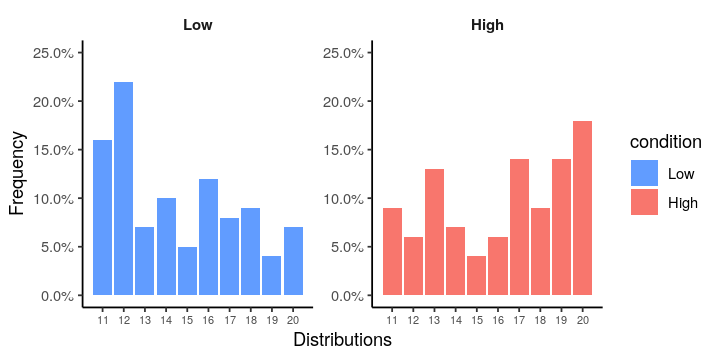

In [26]:
options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(data_long) +
facet_wrap(vars(condition), ncol = 4, scales = "free") +
geom_bar(aes(value, fill = condition, y = ..prop.., group = condition)) +
scale_x_continuous(breaks = seq(11, 20, 1)) +
scale_y_continuous(limits = c(0, 0.25), labels = percent) +
scale_fill_manual(values=c("#619CFF", "#F8766D")) +
xlab("Distributions") +
ylab("Frequency") +
theme_classic() +
theme(
  axis.text.x = element_text(size = rel(0.75)),
  strip.text = element_text(face = "bold", size = 9),
  strip.background = element_rect(fill = NULL, colour = "black", size = 0)
)

## 3. Analyzing properties of the distributions

**The analysis of the data always depends on the research question.**

So far, we have taken a descriptive approach to the data: We considered that we have collected 10 values from each participant, and have analyzed the data as such.

However, we could have collected the data with the specific goal of testing people’s beliefs about particular properties of the distribution:

* We could be interested in what is the average value that people expect (i.e., the mean)
* We could be interested in how dispersed participants expect the distribution to be (e.g., the standard deviation).
* We could be interested in how skewed they expect it to be (i.e., the kurtosis)

In that case, the relevant unit of analysis is the statistics computed at the distribution’s level.

We need to group the data by part_id, and compute the statistics of interest, to obtain one data point per participant.

In [9]:
data_summary <- data_long %>%
  group_by(condition, part_id) %>%
  summarise(Dist_SD = sd(value), Dist_M = mean(value), .groups = "drop")
head(data_summary, 5)

condition,part_id,Dist_SD,Dist_M
<fct>,<fct>,<dbl>,<dbl>
Low,A,3.713339,14.7
Low,D,3.212822,15.1
Low,E,3.622461,14.7
Low,G,2.233582,13.9
Low,J,2.740641,14.2


We can now see if our condition had an impact on people’s perceived mean of the distribution:

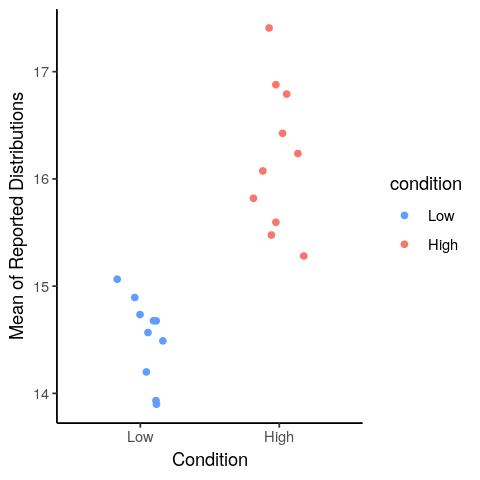

In [24]:
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(data_summary, aes(x = condition, y = Dist_M, color = condition)) +
geom_jitter(width = 0.2) +
xlab("Condition") +
ylab("Mean of Reported Distributions") +
scale_color_manual(values = c("#619CFF", "#F8766D")) +
theme_classic()

Here, we see that participants in the “Low” condition reported a significantly lower mean that participants in the “High” condition (which is exactly how I created the data, so not so surprising…).

## 4. Wrapping Up

We have seen how to convert the raw data generated by distBuilder to a standard long form dataset.

A few words of caution to finish:

* Always check that the list of buckets you use in the analysis matches the list of buckets that was shown to participants.
* Always check your number of records. If something is off, you might have missing data, or you might not have forced participants to submit a full distribution.
* Always ask yourself: what is my unit of analysis? Is it the values provided by participants, or is it a summary statistics of their total reported distribution?